In [1]:
 
import tensorflow as tf
import numpy
import scipy.io
#from tensorflow.python.client import timeline
import time

quantiMesi = 1
quantiHertz = 1



percorsoDati = "/home/protoss/Documenti/TESI/DATI/in_O2LL_02_0187_.mat"
#percorsoDati = "/home/protoss/Documenti/TESI/DATI/dati9mesi052HWI.mat"
#percorsoDati = "/home/protoss/Documenti/TESI/DATI/datiOLDmesi108HWI.mat"
#percorsoDati = "/home/protoss/wn100bkp/dati/datiunmese.mat"


#tFft = 8192
tFft = 4096
tObs = quantiMesi #mesi
tObs = tObs*30*24*60*60

#carico file dati
struttura = scipy.io.loadmat(percorsoDati)['job_pack_0']

#peakmap = struttura['peaks'][0,0]
#print(peakmap)
#tempiIndiciSorted = numpy.argsort(peakmap[0,:])
#tempi = peakmap[0, tempiIndiciSorted]
#frequenze = peakmap[1, tempiIndiciSorted]
#pesi =peakmap[4, tempiIndiciSorted] + 1 #numpy.ones(peakmap[4].size)#

#print(tempi)
#print(frequenze)
#print(pesi)

tempi = struttura['peaks'][0,0][0].astype(numpy.float32)
frequenze = struttura['peaks'][0,0][1].astype(numpy.float32)
pesi = (struttura['peaks'][0,0][4]+1).astype(numpy.float32)



print((numpy.amax(tempi)-numpy.amin(tempi))*24*60*60)


filtro1 = numpy.where(tempi>57800)
tempi = tempi[filtro1]
frequenze = frequenze[filtro1]
filtro2 = numpy.where(tempi<57831)
tempi = tempi[filtro2]
frequenze = frequenze[filtro2]
filtro3 = numpy.where(frequenze<188)
tempi = tempi[filtro3]
frequenze = frequenze[filtro3]

frequenze.size

23129887.5


258203

In [2]:






tempiVecchi = tempi
freqVecchi = frequenze
pesiVecchi = pesi
for i in numpy.arange(1,quantiMesi):
    tempiNuovi = tempiVecchi + i*30
    freqNuovi = freqVecchi
    pesiNuovi = pesiVecchi 
    tempi = numpy.concatenate((tempi,tempiNuovi))
    frequenze = numpy.concatenate((frequenze,freqNuovi))
    pesi = numpy.concatenate((pesi,pesiNuovi))

    
tempiVecchi = tempi
freqVecchi = frequenze
pesiVecchi = pesi    
for j in numpy.arange(1,quantiHertz):
    tempiNuovi = tempiVecchi
    freqNuovi = freqVecchi + j
    pesiNuovi = pesiVecchi
    tempi = numpy.concatenate((tempi,tempiNuovi))
    frequenze = numpy.concatenate((frequenze,freqNuovi))
    pesi = numpy.concatenate((pesi,pesi))


<IPython.core.display.Javascript object>


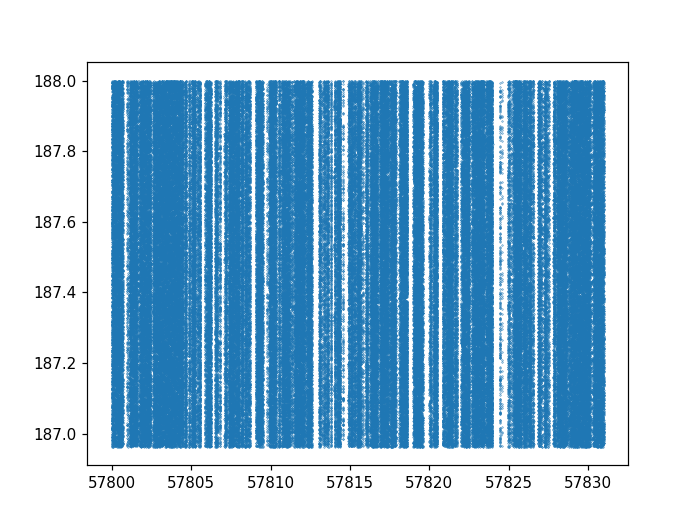

In [95]:
from matplotlib import pyplot
%matplotlib notebook
a = pyplot.scatter(tempi,frequenze, s=0.1)

In [3]:


#nb: picchi ha 0-tempi
#              1-frequenze
#              2-pesi

#headers vari
securbelt = 4000


#frequenze
#frequenze
stepFrequenza = 1/tFft
enhancement = 10
stepFreqRaffinato =  stepFrequenza/enhancement

freqMin = numpy.amin(frequenze)
freqMax = numpy.amax(frequenze)
freqIniz = freqMin- stepFrequenza/2 - stepFreqRaffinato
freqFin = freqMax + stepFrequenza/2 + stepFreqRaffinato
nstepFrequenze = numpy.ceil((freqFin-freqIniz)/stepFreqRaffinato)

#tempi
#epoca definita come mediana di tempi di tutto il run
epoca = (57722+57990)/2 #0
#epoca = 0

#spindowns
spindownMin = -1e-9
spindownMax = 2e-10
stepSpindown = stepFrequenza/tObs 

nstepSpindown = numpy.round((spindownMax-spindownMin)/stepSpindown).astype(numpy.int32)

# riarrangio gli array in modo che abbia i dati 
# nel formato che voglio io
frequenze = frequenze-freqIniz
frequenze = (frequenze/stepFreqRaffinato)-round(enhancement/2+0.001)

tempi = tempi-epoca
tempi = ((tempi)*3600*24/stepFreqRaffinato)
#tempi = numpy.round(tempi/1e8)*1e8

spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownMin)
# così ho i tre array delle tre grandezze, 
#più i pesi e la fascia di sicurezza
 



#ora uso Tensorflow
securbeltTF = tf.constant(securbelt,dtype=tf.float32)
tempiTF = tf.constant(tempi,dtype=tf.float32)
pesiTF = tf.constant(pesi,dtype=tf.float32)
spindownsTF = tf.constant(spindowns, dtype=tf.float32)
frequenzeTF = tf.constant(frequenze, dtype=tf.float32)

nRows = nstepSpindown
nColumns = numpy.int32(nstepFrequenze)
print(nColumns,nRows)

def frequencyHough(nu,t, nuDot, w, numRows, numColumns):
	numColumns = numColumns + securbelt

	def rowTransform(ithSD):
		sdTimed = tf.multiply(nuDot[ithSD], t)

		transform = tf.round(nu-sdTimed+securbeltTF/2)
		transform = tf.cast(transform, dtype=tf.int32)
		values = tf.unsorted_segment_sum(w, transform, numColumns)
		#values = tf.cast(values, dtype=tf.float32)
		return values

	houghLeft = tf.map_fn(rowTransform, tf.range(0, numRows), 
					dtype=tf.float32, parallel_iterations=10)
	houghRight = houghLeft[:,enhancement:numColumns]-houghLeft[:,0:numColumns - enhancement]
	houghDiff = tf.concat([houghLeft[:,0:enhancement],houghRight],1)
	houghMap = tf.cumsum(houghDiff, axis = 1)
	print(sessione.run(houghMap).shape)
	return houghMap 

sessione = tf.Session()

start = time.time()

hough  = frequencyHough(frequenzeTF, tempiTF, spindownsTF,pesiTF,nRows,nColumns)

image = sessione.run(hough)

stop = time.time()
print(stop-start)


from matplotlib import pyplot

pyplot.figure(figsize=(12, 8))

a = pyplot.imshow(image, origin = 'lower', interpolation = 'none', aspect = 300)
pyplot.colorbar(shrink = 0.5,aspect = 15)
pyplot.show()


42492 13


ValueError: Dimensions must be equal, but are 8744670 and 258203 for 'map/while/UnsortedSegmentSum' (op: 'UnsortedSegmentSum') with input shapes: [8744670], [258203], [].